<a href="https://colab.research.google.com/github/machtg/bangkit-final-project/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project Google Bangkit**



BDG5-D 
1. Maclaurin Hutagalung
2. Nur Salam Al Amin
3. Puthut Prabancono
4. Raynald Masli

Our topic is the **lips reading dataset**

**Downloading and Unzipping the Dataset**

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras import backend as Back
from tensorflow.keras.initializers import Constant
from tensorflow.python.framework import ops
from tensorflow.python.ops import state_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.framework import constant_op
from tensorflow.python.training.optimizer import Optimizer
import dlib
import imutils
import zipfile
import time
from tensorflow import keras
import random

The steps below is the syntax to import the dataset from kaggle, so after running the cropping process, we don't need to run this anymore. Just use the final cropping data in zip file.

In [ ]:
from google.colab import files

!pip install -q kaggle

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d apoorvwatsky/miraclvc1

100% 5.12G/5.13G [01:54<00:00, 58.3MB/s]
100% 5.13G/5.13G [01:54<00:00, 48.1MB/s]


In [ ]:
import zipfile

#Extract the file from zip file
images = zipfile.ZipFile("/content/miraclvc1.zip", 'r')
images.extractall("/content")
images.close()

# **Data Preprocessing**

This section contains of;
1. Set random seed
2. Facial detection process
3. Lip cropping process
4. Facial landmarks coordinate extraction
5. Lip cropping images
6. Sequential dataset
7. Data splitting process
8. Independent variables expand dimension

In [ ]:
#Set random number gnerator (RNG)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = 1,
                              inter_op_parallelism_threads = 1)
seeds = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = session_conf)
tf.compat.v1.keras.backend.set_session(seeds)

In [ ]:
#Dataset description in file

respondent = ['F01', 'F02', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 
              'F10', 'F11', 'M01', 'M02', 'M04', 'M07', 'M08']
data_types = ['words']
folder_enumerate = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
instances = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

words = ['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous',
         'Start', 'Stop', 'Hello', 'Web']
phrases = ['Stop Navigation.', 'Excuse me.', 'I am sorry.', 'Thank you.', 
           'Good bye.', 'I love this game.', 'Nice to meet you.',
           'You are welcome.', 'How are you?', 'Have a good time.']


# **This is the syntax to crop all the datasets, if you have extracted it into the zip file, you don't have to run it anymore.** 

In [ ]:
#Facial Landmark Mapping to Numpy Array

def shape_to_np (facial, dtype = 'int'):
#This function is generated to convert the facial landmarks (68 points)
#as the integers in (x,y)-coordinates in 2-dimensional-tuples
    coordinates = np.zeros((68,2), dtype = dtype)
    for i in range(0, 68):
        coordinates[i] = (facial.part(i).x, facial.part(i).y)
    
    return coordinates

In [ ]:
from imutils import face_utils

In [ ]:
#Lip Image Cropping 

def image_cropping(img_path):
#This function is generated to detect and map all the facial landmarks (68 points)
#It also resize the image and save the (x,y) coordinates

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')

    image = cv2.imread(img_path)
    image = imutils.resize(image, width = 500)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    detection = detector(image, 1)

    if len(detection) > 1:
      print('ERROR : Detect more than 1 face')
      return
    if len(detection) < 1:
      print('ERROR : Detect no faces')
      return
    
    for (i, detect) in enumerate(detection) :
      facial = predictor(image, detect)
      facial = face_utils.shape_to_np(facial)
      name, i, j = 'mouth', 48, 68

      (x, y, w, h) = cv2.boundingRect(np.array([facial[i:j]]))
      lip = image[y:y+h, x:x+w]
      lip = imutils.resize(lip, width = 250, inter = cv2.INTER_CUBIC)
      
    return lip


In [ ]:
#Directory Processing

if not os.path.exists('/content/final_cropping_data'):
    os.mkdir('/content/final_cropping_data')
directory = '/content/final_cropping_data/'

for person in respondent :
    t1 = time.time
    if not os.path.exists( directory + person) :
        os.mkdir(directory + person + '/')
    for data in data_types :
        if not os.path.exists(directory + person + '/' + data) :
            os.mkdir(directory + person + '/' + data + '/')
        for context in folder_enumerate :
            if not os.path.exists(directory + person + '/' + data + '/' + 
                                 context) :
                os.mkdir(directory + person + '/' + data + '/' + 
                         context + '/')
            for word in instances :
                if not os.path.exists(directory + person + '/' + data + 
                                     '/' + context + '/' + word) :
                      os.mkdir(directory + person + '/' + data + 
                               '/' + context + '/' + word + '/')
                
                direct_file = '/content/dataset/dataset/' + person + '/' + data + '/' + context + '/' + word + '/'
                save_file = directory + person + '/' + data + '/' + context + '/' + word + '/' 
                pic = os.listdir(direct_file)
                for img in pic :
                    if img.startswith('color') :
                        image = direct_file + img
                        lip = image_cropping(image)
                        cv2.imwrite(save_file + img, lip)
    
    t2 = time.time()
    print(f'Finish for {person}')



Finish for F01
Finish for F02
Finish for F04
Finish for F05
Finish for F06
Finish for F07
Finish for F08
Finish for F09
Finish for F10
Finish for F11
Finish for M01
Finish for M02
Finish for M04
Finish for M07
Finish for M08


In [ ]:
import shutil

In [ ]:
shutil.make_archive('final_cropping_data', 'zip', base_dir = '/content/final_cropping_data')

'final_cropping_data.zip'

# **Running cells process starts here** 

After extracting all the images into zip file, download it and then it can be uploaded again if the model want to be develop more. The download process must be done since the cropping process spends about 5 hours per running

In [ ]:
#Upload zip file of cropping dataset from the computer
from google.colab import files

uploaded = files.upload()

Saving final_cropping_data.zip to final_cropping_data.zip


In [ ]:
#Extract the file from file_data_cropping zip file
images = zipfile.ZipFile("/content/final_cropping_data.zip", 'r')
images.extractall("/content")
images.close()

In [ ]:
#Reading Initialization
max_sequence_len = 22
Max_width = 100
Max_height = 100

X_train = []
Y_train = []
X_val = []
Y_val = []
X_test = []
Y_test = []


In [ ]:
Validation_data = ['F05', 'M04']
Test_data = ['F08']

directory = '/content/content/final_cropping_data'

for person in respondent :
    ti = time.time()
    for data in data_types :
        for word_index, word in enumerate(folder_enumerate) :
            for context in instances :
                image_path = os.path.join(directory, person, data, word, context)
                image_list = sorted(os.listdir(image_path + '/'))
                sequence = []
                for img in image_list :
                    image = cv2.imread(image_path + '/' + img)
                    image = cv2.resize(image, (Max_width, Max_height))
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    image = image.astype(np.uint8)
                    sequence.append(image)
                
                padded_arr = [np.zeros((Max_width, Max_height))]
                sequence.extend(padded_arr * (max_sequence_len - len(sequence)))
                sequence = np.array(sequence)


                if person in Validation_data :
                    X_val.append(sequence)
                    Y_val.append(word_index)
                elif person in Test_data :
                    X_test.append(sequence)
                    Y_test.append(word_index)
                else :
                    X_train.append(sequence)
                    Y_train.append(word_index)
    tf = time.time()
    print(f'Finish for {person}, in {tf - ti} secs.')

Finish for F01, in 0.5120916366577148 secs.
Finish for F02, in 0.48088979721069336 secs.
Finish for F04, in 0.7711741924285889 secs.
Finish for F05, in 0.6170346736907959 secs.
Finish for F06, in 0.668999195098877 secs.
Finish for F07, in 0.6807835102081299 secs.
Finish for F08, in 0.5542306900024414 secs.
Finish for F09, in 0.5515751838684082 secs.
Finish for F10, in 0.46953511238098145 secs.
Finish for F11, in 0.4500272274017334 secs.
Finish for M01, in 0.5617244243621826 secs.
Finish for M02, in 0.7262301445007324 secs.
Finish for M04, in 0.5941324234008789 secs.
Finish for M07, in 0.4946112632751465 secs.
Finish for M08, in 0.43662405014038086 secs.


In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1200, 22, 100, 100)
(200, 22, 100, 100)
(100, 22, 100, 100)


In [ ]:
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)

print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(1200,)
(200,)
(100,)


In [ ]:
#Normalization process

X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

In [ ]:
#Transforming Y feature to the categorical feature and randomization process
from tensorflow import keras

Y_train = keras.utils.to_categorical(Y_train, 10)
Y_val = keras.utils.to_categorical(Y_val, 10)
Y_test = keras.utils.to_categorical(Y_test, 10)


In [ ]:
X_train = np.expand_dims(X_train, axis = 4)
X_val = np.expand_dims(X_val, axis = 4)
X_test = np.expand_dims(X_test, axis = 4)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1200, 22, 100, 100, 1)
(200, 22, 100, 100, 1)
(100, 22, 100, 100, 1)


# **Model Development (LipNet)** 

The model development process using two references in papers to increase the accuracy and the running speed. The model development steps can be identify below :
1. Random optimizer model function
2. Callbacks model function
3. Model development
4. Running process
5. Result 
6. Model saving and deployment

In [ ]:
import tensorflow as tf

class Cont_Coin_Betting (Optimizer) :

    def __init__(self, alpha = 100, use_locking = False, name = 'Cont_Coin_Betting') :
        super(Cont_Coin_Betting, self).__init__(use_locking, name)
        self._alpha = alpha

    def _create_slots(self, var_list) :
        for v in var_list :
            with ops.colocate_with(v) :
                grad_total = constant_op.constant(0, shape = v.get_shape(),
                                                  dtype = v.dtype.base_dtype)
                grad_total_norm = constant_op.constant(0, shape = v.get_shape(),
                                                       dtype = v.dtype.base_dtype)
                L = constant_op.constant(1e-8, shape = v.get_shape(),
                                         dtype = v.dtype.base_dtype)
                w_tilde = constant_op.constant(0.0, shape = v.get_shape(), 
                                               dtype = v.dtype.base_dtype)
                reward = constant_op.constant(0.0, shape = v.get_shape(), 
                                              dtype = v.dtype.base_dtype)
            
            self._get_or_make_slot(v, L, 'L', self._name)
            self._get_or_make_slot(v, grad_total, 'grad_total', self._name)
            self._get_or_make_slot(v, grad_total_norm, 'grad_total_norm', self._name)
            self._get_or_make_slot(v, w_tilde, 'w_tilde', self._name)
            self._get_or_make_slot(v, reward, 'reward', self._name)

    def _apply_dense(self, grad, var) :
        grad_total = self.get_slot(var, 'grad_total')
        grad_total_norm = self.get_slot(var, 'grad_total_norm')
        w_tilde = self.get_slot(var, 'w_tilde')
        L = self.get_slot(var, 'L')
        reward = self.get_slot(var, 'reward')

        L_update = tf.maximum(L, tf.abs(grad))
        grad_total_update = grad_total + grad
        grad_total_norm_update = grad_total_norm + tf.abs(grad)
        reward_update = tf.maximum(reward - grad * w_tilde, 0)
        w_tilde_update = -grad_total_update / (L_update * (tf.maximum(grad_total_norm_update + L_update, self._alpha * L_update))) * (reward_update + L_update)
        var_update = var - w_tilde + w_tilde_update

        grad_total_update_op = state_ops.assign(grad_total, grad_total_update)
        grad_total_norm_update_op = state_ops.assign(grad_total_norm, grad_total_norm_update)
        var_update_op = state_ops.assign(var, var_update)
        w_tilde_update_op = state_ops.assign(w_tilde, w_tilde_update)
        L_update_op = state_ops.assign(L, L_update)
        reward_update_op = state_ops.assign(reward, reward_update)

        return control_flow_ops.group(*[grad_total_update_op, var_update_op, 
                                        grad_total_norm_update_op, w_tilde_update_op,
                                        reward_update_op, L_update_op])
        
    def _apply_sparse(self, grad, var) :
        return self._apply_dense(grad, var)

    def _resource_apply_dense(self, grad, handle) :
        return self._apply_dense(grad, handle)

    def get_config(self):
        config = {'alpha': float(K.get_value(self._alpha)) }
        base_config = super(Cont_Coin_Betting(), self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
class myCallback (keras.callbacks.Callback) :
    def on_epoch_end (self, epoch, logs = {} ) :
        if (logs.get('accuracy') > 0.97) :
            print('\n Accuracy is high enough so running is cancelled')
            self.model.stop_training = True

In [ ]:
callbacks = myCallback()

In [ ]:
def LipNNvar ():

  model = Sequential()
  model.add(ZeroPadding3D(padding = (1, 2, 2), input_shape = (22, 100, 100, 1)))
  model.add(Conv3D(32, (3, 5, 5), strides = (1, 2, 2), activation = PReLU(Constant(value = 0.25))))
  model.add(SpatialDropout3D(0.5))
  model.add(MaxPooling3D((1, 2, 2), strides = (1, 2, 2)))
  model.add(ZeroPadding3D(padding = (1, 2, 2)))
  model.add(Conv3D(64, (3, 5, 5), strides = (1, 2, 2), activation = PReLU(Constant(value = 0.25))))
  model.add(SpatialDropout3D(0.5))
  model.add(MaxPooling3D((1, 2, 2), strides = (1, 2, 2)))
  model.add(ZeroPadding3D(padding = (1, 2, 2)))
  model.add(Conv3D(96, (3, 5, 5), strides = (1, 2, 2), activation = PReLU(Constant(value = 0.25))))
  model.add(SpatialDropout3D(0.5))
  model.add(MaxPooling3D((1, 2, 2), strides = (1, 2, 2)))

  model.add(TimeDistributed(Flatten()))

  model.add(Bidirectional(LSTM(32, return_sequences = True)))
  model.add(Bidirectional(LSTM(32,  return_sequences = True)))
  model.add(Dropout(0.5))
  model.add(Flatten())

  model.add(Dense(1024, activation = PReLU(Constant(value = 0.25))))
  model.add(Dropout(0.5))
  model.add(Dense(512, activation = PReLU(Constant(value = 0.25))))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'softmax'))

  return model

In [ ]:
def LipNN ():

  model = Sequential()
  model.add(Conv3D(32, (3, 3, 3), strides = 1, input_shape = (22, 100, 100, 1), activation = PReLU(Constant(value = 0.25))))
  model.add(SpatialDropout3D(0.2))
  model.add(MaxPooling3D((2, 2, 2), strides = 2))
  model.add(Conv3D(64, (3, 3, 3), strides = 1, activation = PReLU(Constant(value = 0.25))))
  model.add(SpatialDropout3D(0.2))
  model.add(MaxPooling3D((2, 2, 2), strides = 2))
  model.add(Conv3D(128, (3, 3, 3), strides = 1, activation = PReLU(Constant(value = 0.25))))
  model.add(SpatialDropout3D(0.2))
  model.add(MaxPooling3D((2, 2, 2), strides = 2))

  shape = model.get_output_shape_at(0)
  model.add(Reshape((shape[-1],shape[1]*shape[2]*shape[3])))

  model.add(Bidirectional(LSTM(32, return_sequences = True)))
  model.add(Bidirectional(LSTM(32,  return_sequences = True)))
  model.add(Dropout(0.5))
  model.add(Flatten())

  model.add(Dense(2048, activation = PReLU(Constant(value = 0.25))))
  model.add(Dropout(0.5))
  model.add(Dense(1024, activation = PReLU(Constant(value = 0.25))))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'softmax'))

  return model

In [ ]:
model = LipNN()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 98, 98, 32)    6147456   
_________________________________________________________________
spatial_dropout3d (SpatialDr (None, 20, 98, 98, 32)    0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 49, 49, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 47, 47, 64)     1186368   
_________________________________________________________________
spatial_dropout3d_1 (Spatial (None, 8, 47, 47, 64)     0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 23, 23, 64)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 21, 21, 128)    3

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = Cont_Coin_Betting(), metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, batch_size = 10, epochs = 200, 
                    validation_data = (X_val, Y_val), shuffle = True, 
                    callbacks = [callbacks])

Epoch 1/200
120/120 [==============================] - 46s 380ms/step - loss: 13.8831 - accuracy: 0.1075 - val_loss: 2.3629 - val_accuracy: 0.1000
Epoch 2/200
120/120 [==============================] - 44s 366ms/step - loss: 2.3317 - accuracy: 0.1067 - val_loss: 2.2481 - val_accuracy: 0.1100
Epoch 3/200
120/120 [==============================] - 44s 365ms/step - loss: 2.3093 - accuracy: 0.1225 - val_loss: 2.2458 - val_accuracy: 0.1550
Epoch 4/200
120/120 [==============================] - 44s 366ms/step - loss: 2.2929 - accuracy: 0.1225 - val_loss: 2.2406 - val_accuracy: 0.1100
Epoch 5/200
120/120 [==============================] - 44s 366ms/step - loss: 2.3056 - accuracy: 0.1342 - val_loss: 2.2330 - val_accuracy: 0.2200
Epoch 6/200
120/120 [==============================] - 44s 366ms/step - loss: 2.2894 - accuracy: 0.1233 - val_loss: 2.2491 - val_accuracy: 0.1050
Epoch 7/200
120/120 [==============================] - 44s 365ms/step - loss: 2.2563 - accuracy: 0.1483 - val_loss: 2.1948 

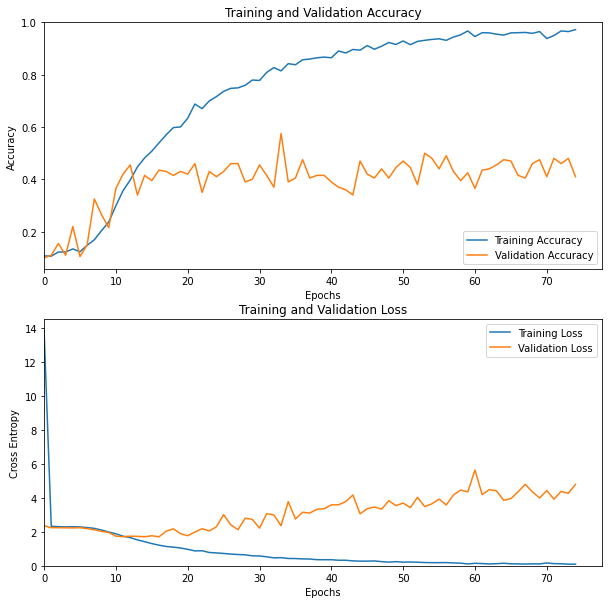

In [ ]:
## Model validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlabel('Epochs')
plt.xlim([0, max(plt.xlim())])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.xlim([0, max(plt.xlim())])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.show()

In [ ]:
#Prediction for testing data
Y_pred = model.predict(X_test)

predicted_words = [words[i] for i in np.argmax(Y_pred, axis=1)]
actual_words = [words[i] for i in np.argmax(Y_test, axis=1)]

correct = 0
for predicted, actual in zip(predicted_words, actual_words):
    if predicted == actual:
        correct += 1
#     print(f"Predicted : {p} \t Actual : {a}")

accuracy = correct/len(actual_words)
print(f"Accuracy : {accuracy} on completely unseen data")

Accuracy : 0.68 on completely unseen data


In [ ]:
saved_model_dir = 'save/model_final'
tf.keras.models.save_model(model, saved_model_dir, include_optimizer = True, save_format = 'tf')

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/model_final/assets


AttributeError: ignored